In [ ]:
import zipfile
import os
import random
import shutil
import yaml
import numpy as np

#Extract Dataset

In [ ]:
zip_file_path = "/content/bottledataset6.zip"
extract_dir = "/content/bottledataset6"

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

#Instalation

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17483, done.
remote: Counting objects: 100% (105/105), done.
remote: Compressing objects: 100% (76/76), done.
remote: Total 17483 (delta 77), reused 29 (delta 29), pack-reused 17378 (from 4)
Receiving objects: 100% (17483/17483), 16.35 MiB | 27.05 MiB/s, done.
Resolving deltas: 100% (11988/11988), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/

#Training

In [ ]:
%pip install -U albumentations

albumentations_transform = [
    {"RandomBrightnessContrast": {"p": 0.5}},
    {"HorizontalFlip": {"p": 0.5}},
    {"Blur": {"blur_limit": 3, "p": 0.3}},
    {"CLAHE": {"clip_limit": 4.0, "p": 0.3}},
    {"HueSaturationValue": {
        "hue_shift_limit": 10,
        "sat_shift_limit": 15,
        "val_shift_limit": 10,
        "p": 0.3
    }}
]

with open("/content/yolov5/albumentations.yaml", "w") as f:
    yaml.dump(albumentations_transform, f)

print("Albumentations config saved.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 9.5 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.6
    Uninstalling albumentations-2.0.6:
      Successfully uninstalled albumentations-2.0.6
Albumentations config saved.


In [ ]:
dataset_path = "/content/yolov5/utils/dataloaders.py"

albumentation_patch = """
import albumentations as A
from albumentations.pytorch import ToTensorV2

def get_albumentations():
    return A.Compose([
        A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=0.7),
        A.HueSaturationValue(hue_shift_limit=15, sat_shift_limit=25, val_shift_limit=10, p=0.6),
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.4),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
        A.Blur(blur_limit=3, p=0.3),
        A.MedianBlur(blur_limit=3, p=0.3),
        A.MotionBlur(blur_limit=5, p=0.2),
        A.Sharpen(alpha=(0.1, 0.3), lightness=(0.8, 1.0), p=0.3),
        A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, num_shadows_upper=2, p=0.3),
        A.RandomFog(fog_coef_lower=0.1, fog_coef_upper=0.3, alpha_coef=0.1, p=0.2),
        A.RandomSunFlare(flare_roi=(0, 0, 1, 0.5), angle_lower=0.5, p=0.2),
        A.RandomRain(p=0.2),
        A.InvertImg(p=0.1),  # useful for checking transparency or light objects
        A.ChannelShuffle(p=0.2),  # for differentiating color channels
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.Rotate(limit=15, border_mode=0, p=0.4),
        A.Resize(640, 640),  # optional, depends on your model input size
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))
"""

with open(dataset_path, "r") as f:
    lines = f.readlines()

if "get_albumentations" not in "".join(lines):
    for idx, line in enumerate(lines):
        if line.startswith("import") and "torch" in line:
            insert_line = idx + 1
            break
    lines.insert(insert_line, albumentation_patch + "\n")

replaced = False
for i, line in enumerate(lines):
    if "self.transforms = transforms" in line:
        lines[i] = "        self.transforms = get_albumentations()\n"
        replaced = True
        break

if replaced:
    with open(dataset_path, "w") as f:
        f.writelines(lines)
    print("Successfully injected")
else:
    print("Not found")

Successfully injected


#YOLOv5s

In [ ]:
!pip uninstall -y wandb

Found existing installation: wandb 0.19.11
Uninstalling wandb-0.19.11:
  Successfully uninstalled wandb-0.19.11


In [ ]:
!python train.py \
  --img 640 \
  --batch 16 \
  --epochs 50 \
  --data /content/bottledataset6/data.yaml \
  --weights yolov5s.pt \
  --project defect_detection \
  --name yolov5s_results

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
2025-05-21 17:04:32.481423: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747847072.817144    3174 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747847072.901380    3174 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=/content/bottledataset6/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_

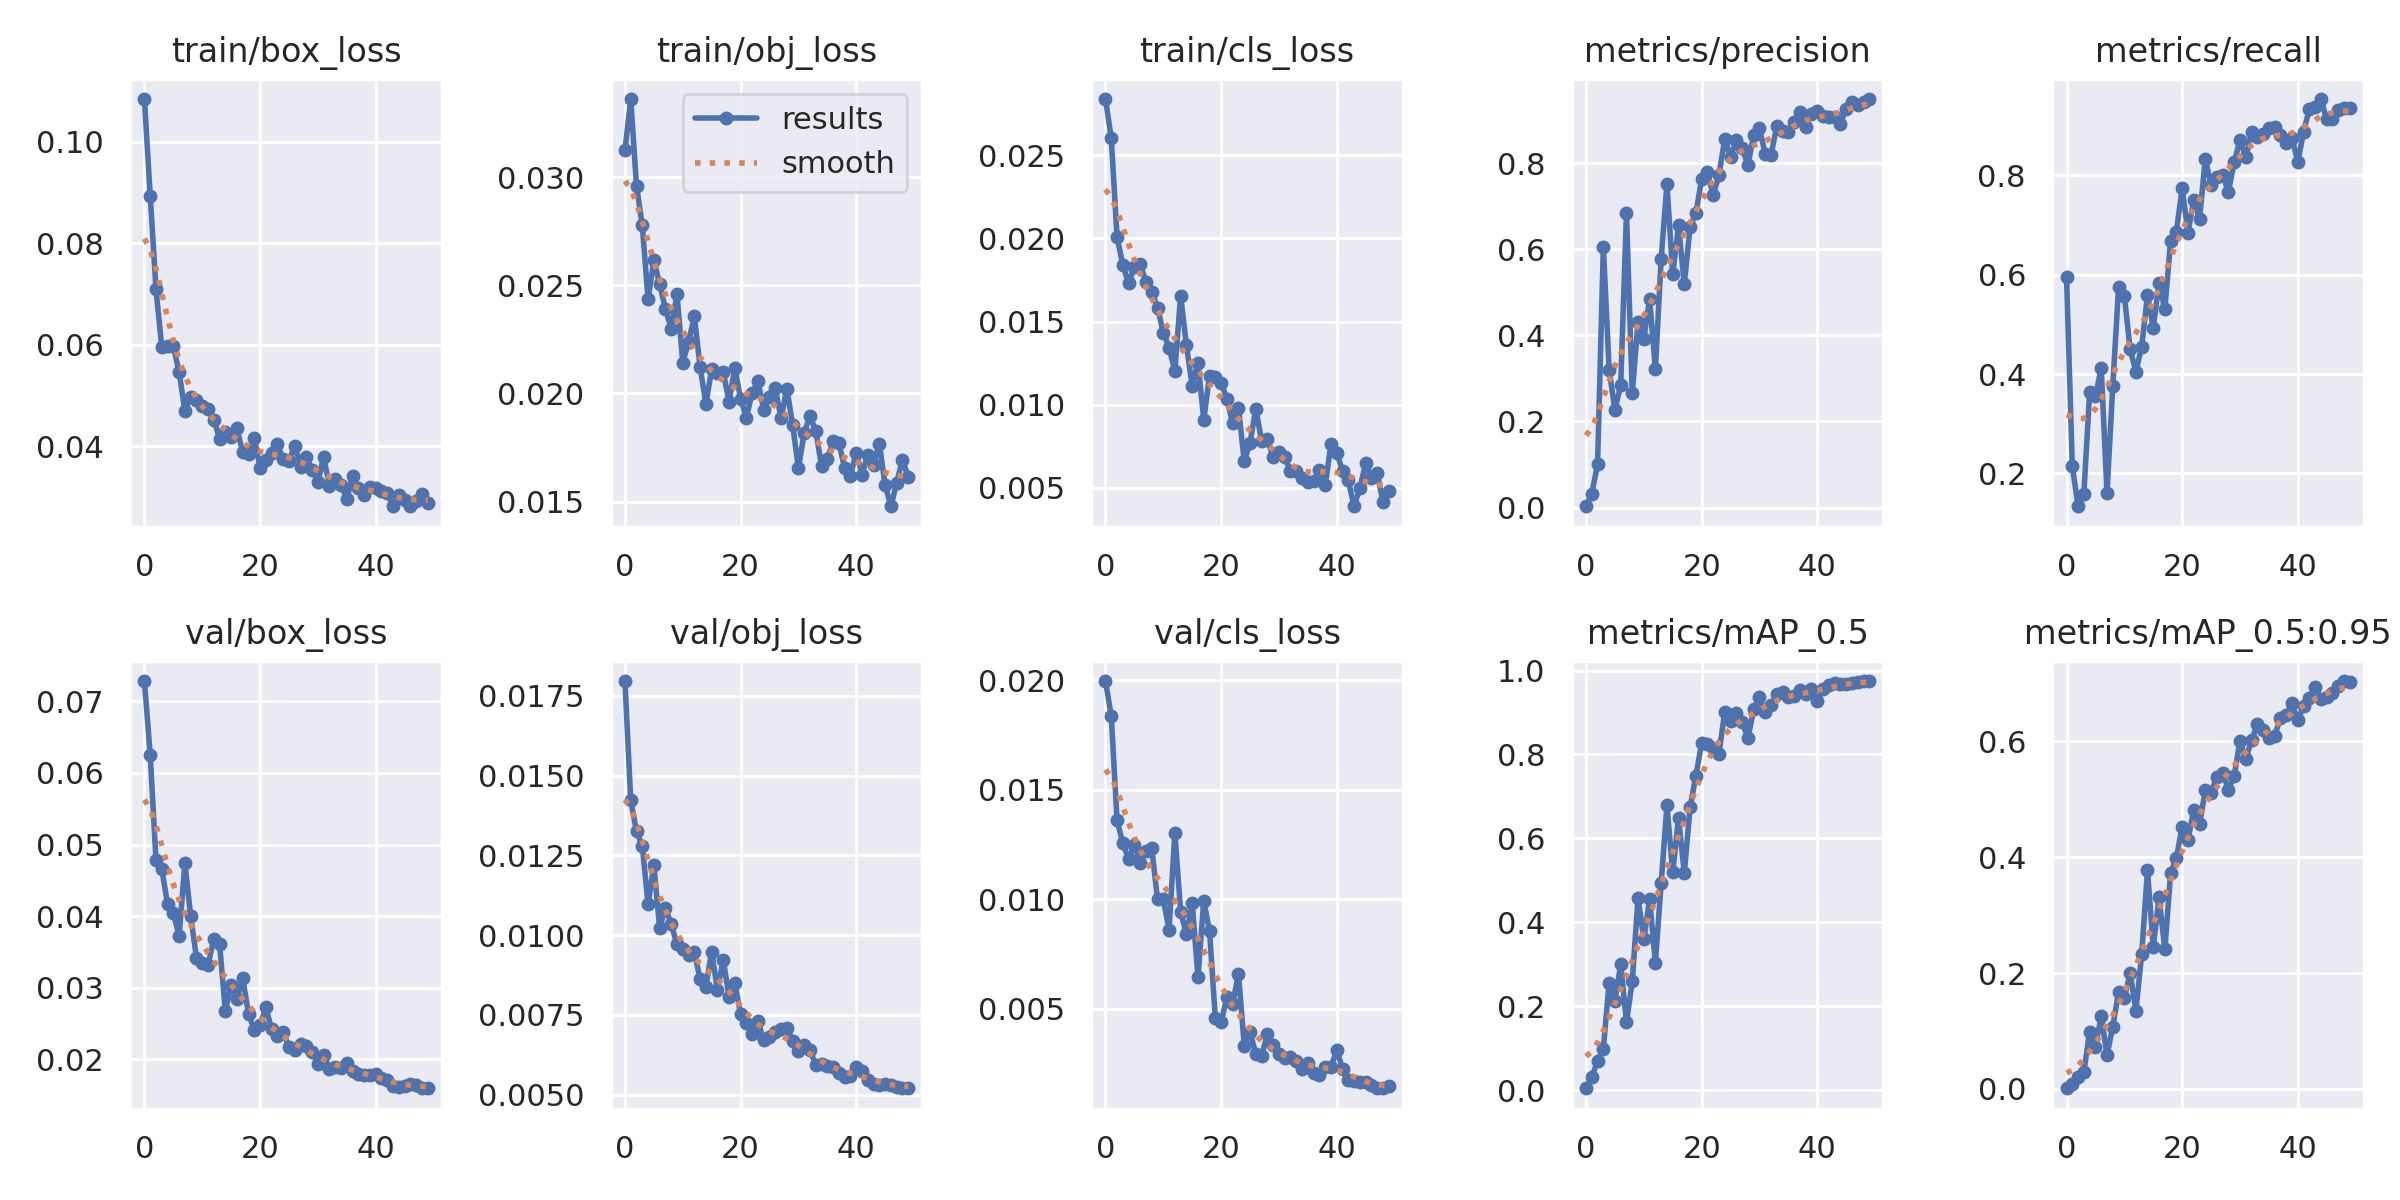

In [ ]:
from IPython.display import Image
Image(filename='/content/yolov5/defect_detection/yolov5s_results/results.png')

In [ ]:
!python val.py \
  --data /content/bottledataset6/data.yaml \
  --weights /content/yolov5/defect_detection/yolov5s_results/weights/best.pt \
  --task test \
  --save-txt \
  --save-conf

val: data=/content/bottledataset6/data.yaml, weights=['/content/yolov5/defect_detection/yolov5s_results/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=True, save_hybrid=False, save_conf=True, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-419-gcd44191c Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /content/bottledataset6/labels/test.cache... 309 images, 0 backgrounds, 0 corrupt: 100% 309/309 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 10/10 [00:08<00:00,  1.22it/s]
                   all        309        490      0.943      0.933      0.975      0.703
                defect        309        167      0.925      0.885    

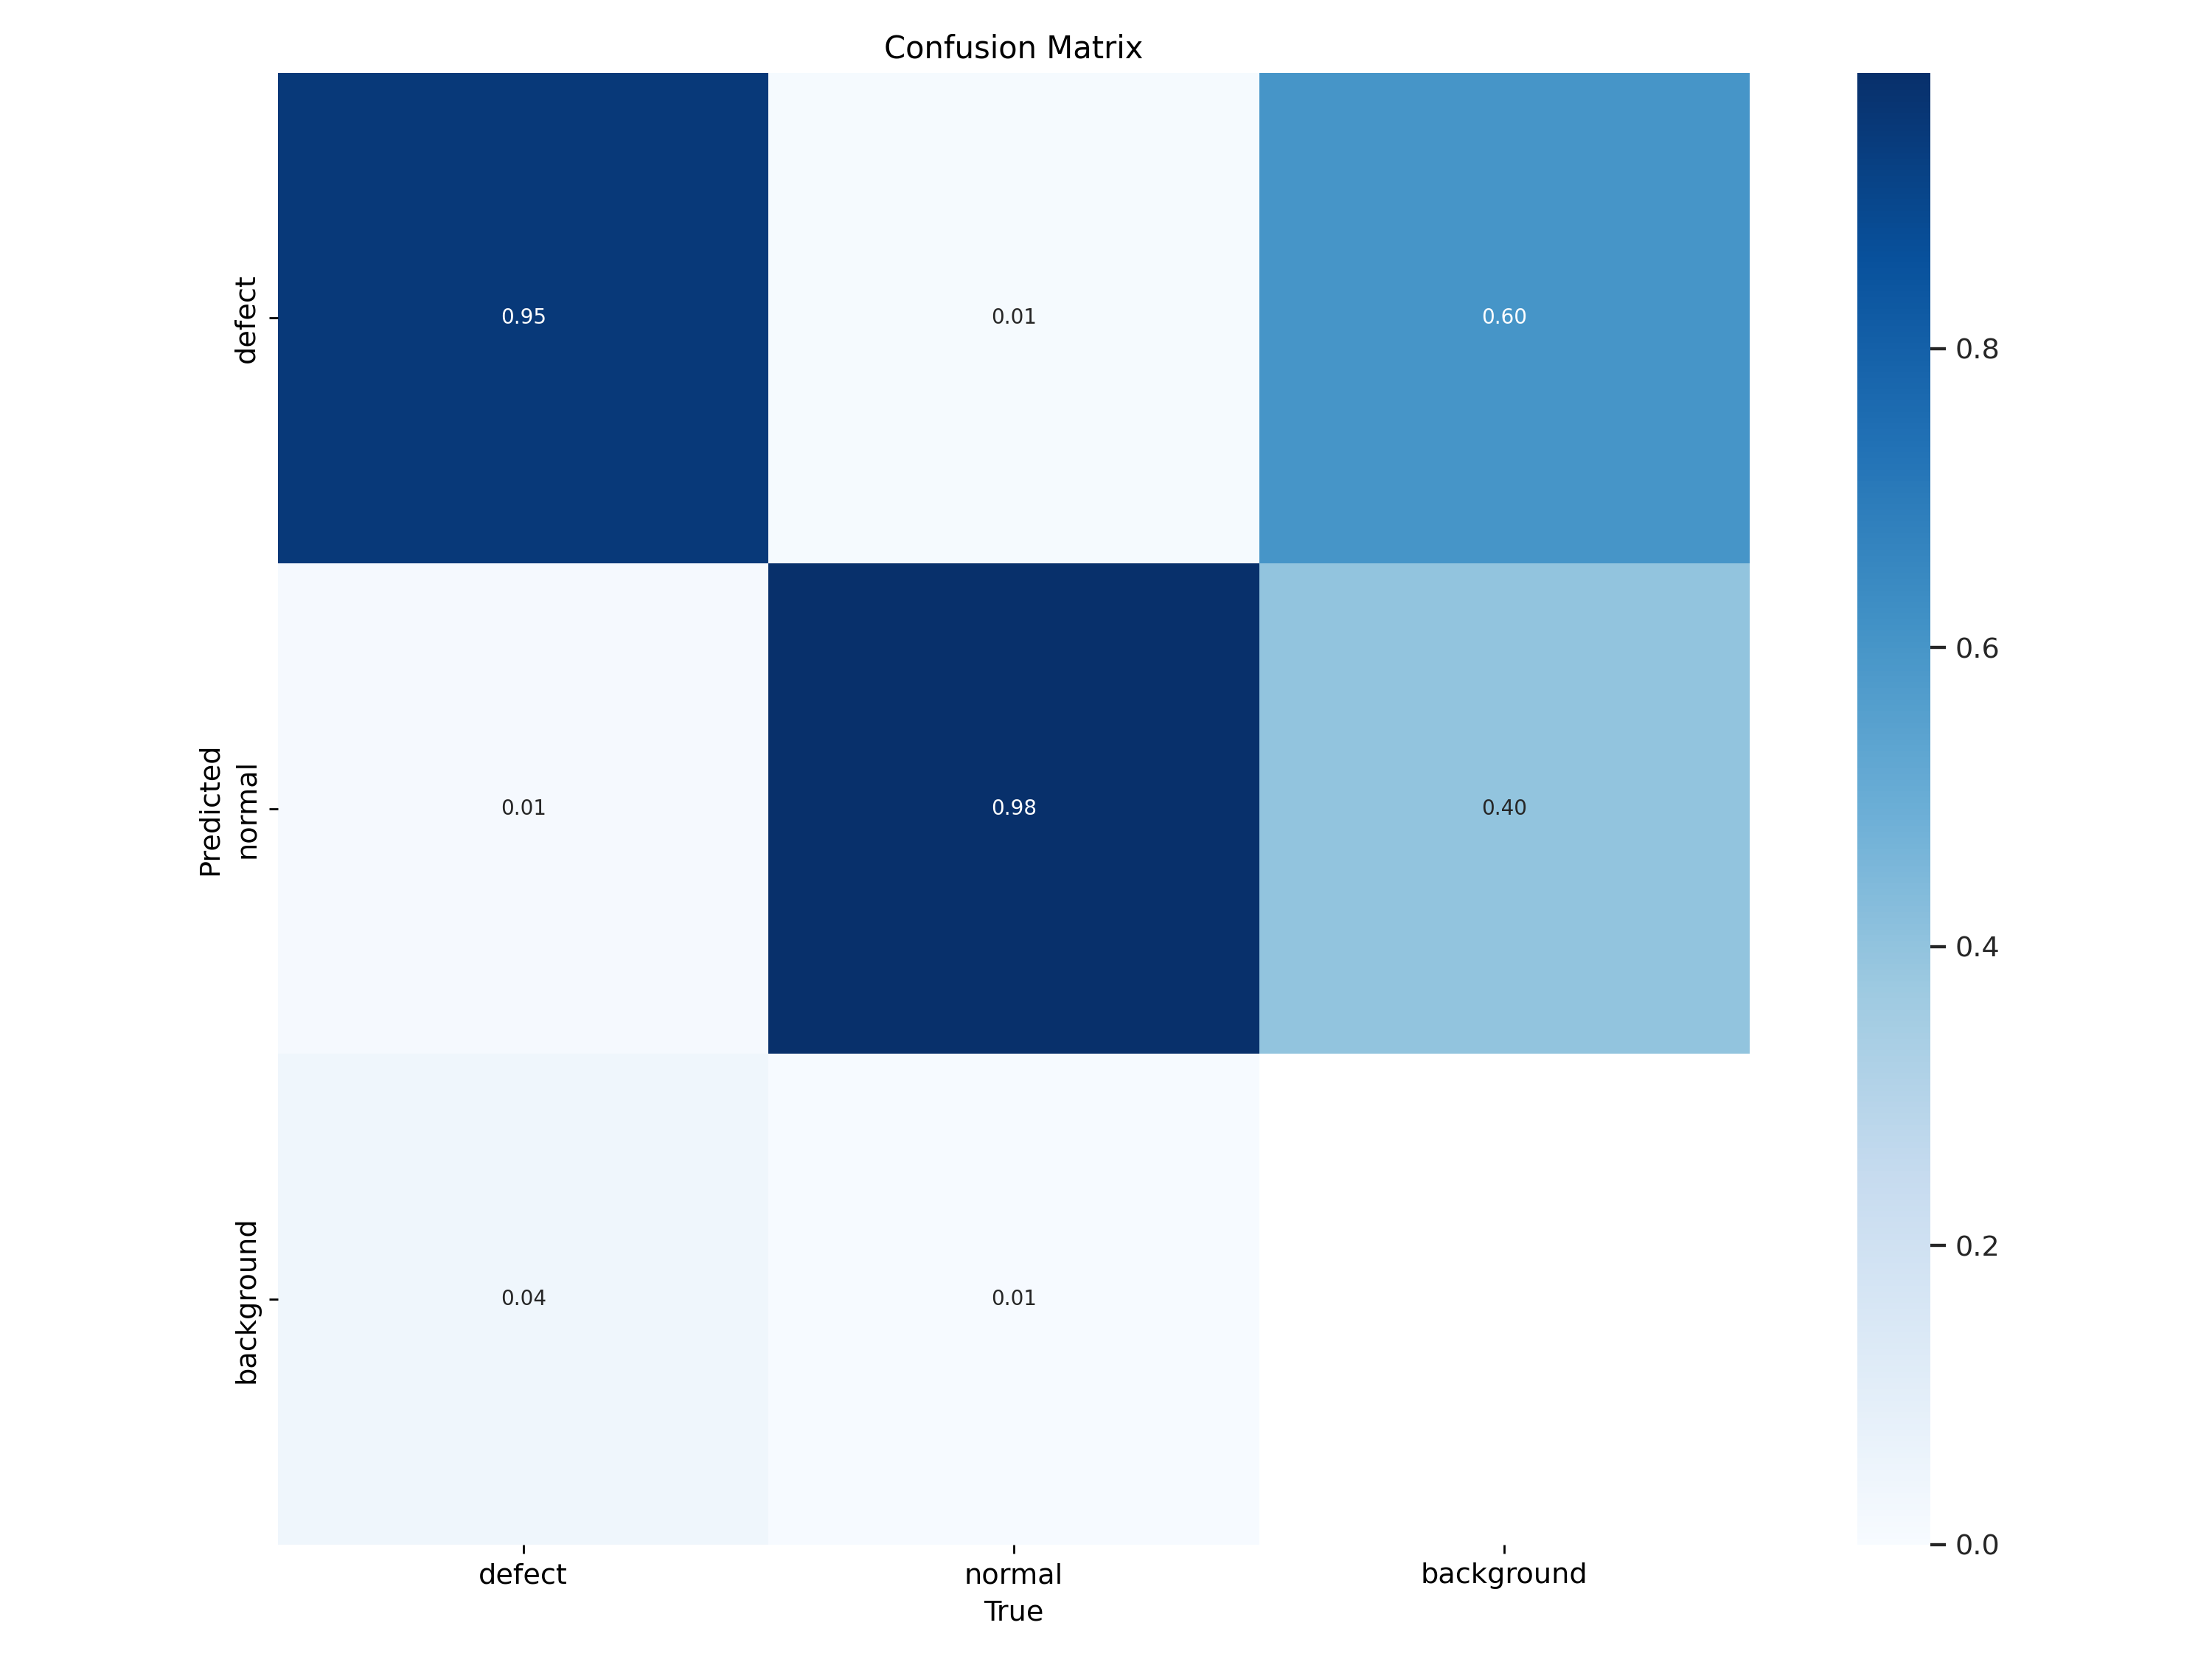

In [ ]:
Image(filename='runs/val/exp3/confusion_matrix.png')

#Save Model

In [ ]:
source_model_path = "/content/yolov5/defect_detection/yolov5s_results/weights/best.pt"
target_model_path = "/content/yolov5s_bottle6.pt"

shutil.copy(source_model_path, target_model_path)
print("Model in:", target_model_path)

Model in: /content/yolov5s_bottle6.pt


#Testing

In [ ]:
%pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.3 MB/s eta 0:00:00


In [ ]:
import torch
import gradio as gr
import numpy as np
from PIL import Image
import cv2

model = torch.hub.load('ultralytics/yolov5', 'custom', path='/content/yolov5s_bottle6.pt', force_reload=False)
model.conf = 0.25

def detect_defect(image):
    img = np.array(image)

    results = model(img)

    new_labels = []
    for pred in results.pred:
        labels = []
        for *box, conf, cls in pred:
            class_id = int(cls.item())
            label = model.names[class_id]
            labels.append(label)
        new_labels.append(labels)

    for i, im in enumerate(results.ims):
        for j, (*box, conf, cls) in enumerate(results.pred[i]):
            x1, y1, x2, y2 = map(int, box)
            label = new_labels[i][j]

            im = cv2.rectangle(im, (x1, y1), (x2, y2), (0, 0, 255), 2)

            (text_w, text_h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.9, 2)

            text_x = x1
            text_y = y1 - 10 if y1 - 10 > text_h else y1 + text_h + 10

            cv2.rectangle(im, (text_x, text_y - text_h), (text_x + text_w, text_y), (0, 0, 255), -1)

            im = cv2.putText(im, label, (text_x, text_y), cv2.FONT_HERSHEY_SIMPLEX,
                             0.9, (255, 255, 255), 2)

        results.ims[i] = im

    result_img = Image.fromarray(results.ims[0])
    return result_img

/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


YOLOv5 🚀 2025-5-21 Python-3.11.12 torch-2.6.0+cu124 CPU

Fusing layers... 
Model summary: 157 layers, 7015519 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


In [ ]:
interface = gr.Interface(
    fn=detect_defect,
    inputs=gr.Image(type="pil"),
    outputs=gr.Image(type="pil"),
    title="Defect Detection YOLOv5",
    description="Upload image."
)

interface.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://697b4d1a46009f20c6.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):
/root/.cache/torch/hub/ultralytics_yolov5_master/models/common.py:906: FutureWarning: `torch.cuda.am

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://697b4d1a46009f20c6.gradio.live
